# Comparision between linear and non-linear classifier in quantification

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import baycomp as bc
import glob
import os
from tqdm import tqdm

## Load results

In [3]:
results = pd.read_csv("results_distance_methods_20x50.csv")
results.truth = results.truth.round()

## Summaries

In [4]:
mae_results = results.groupby(['method'])[['mae']].agg(['mean', 'median'])
mae_results

mae          
            mean    median
method                    
AC      0.059029  0.033992
CvMy    0.066788  0.044399
EDX     0.053872  0.036090
EDy     0.056268  0.034195
HDX     0.066850  0.042827
HDy     0.058556  0.032812

In [5]:
results.groupby(['dataset', 'method'])[['mae']].agg(["mean", "median"]).unstack()

mae                                          \
                        mean                                           
method                    AC      CvMy       EDX       EDy       HDX   
dataset                                                                
acute.a             0.037108  0.063550  0.043139  0.045118  0.055545   
acute.b             0.032788  0.066146  0.036890  0.041999  0.041406   
balance.1           0.035783  0.033945  0.023380  0.030977  0.031761   
balance.3           0.036954  0.041549  0.031478  0.036346  0.038860   
breast-cancer       0.016127  0.041405  0.021433  0.019083  0.020661   
cmc.1               0.086332  0.078364  0.078307  0.076136  0.069633   
cmc.2               0.107941  0.119897  0.067238  0.115609  0.070623   
cmc.3               0.123313  0.102359  0.097244  0.094503  0.089708   
coil                0.074547  0.088761  0.091519  0.084081  0.152487   
ctg.1               0.015548  0.024147  0.029277  0.017414  0.039771   
ctg.2               0.029396  0.034666  0.033221  0.029420  0.035380   
ctg.3               0.036554  0.034602  0.037974  0.028830  0.072301   
default_credit      0.019715  0.022824  0.019998  0.020298  0.019029   
diabetes            0.072729  0.054864  0.059925  0.053669  0.079258   
german              0.087824  0.094541  0.078250  0.094154  0.100175   
haberman            0.243842  0.249899  0.166582  0.235816  0.263772   
ionosphere          0.048585  0.066306  0.060841  0.055436  0.055167   
iris.1              0.002824  0.093470  0.016286  0.019482  0.019413   
iris.2              0.055456  0.072105  0.083458  0.048620  0.050365   
iris.3              0.056763  0.066537  0.048433  0.046074  0.040583   
lettersH            0.020787  0.026393  0.027549  0.025537  0.024807   
mammographic        0.055443  0.049573  0.047413  0.044584  0.040516   
normtrans           0.126085  0.115678  0.083582  0.111233  0.184914   
normwine.1          0.044364  0.053990  0.031585  0.037656  0.036819   
normwine.2          0.050073  0.052678  0.041247  0.044185  0.067116   
normwine.3          0.043011  0.058478  0.037641  0.037738  0.058761   
pageblocks.5        0.042875  0.045982  0.056530  0.042546  0.116209   
phoneme             0.016554  0.019391  0.020960  0.015883  0.017325   
semeion.8           0.058507  0.058614  0.086534  0.058085  0.053439   
sonar               0.113939  0.108738  0.103082  0.107576  0.126948   
spambase            0.008127  0.015965  0.011639  0.010721  0.020363   
spectf              0.184524  0.162914  0.105445  0.150938  0.088333   
tictactoe           0.048306  0.061411  0.081694  0.056250  0.078846   
transfusion         0.107033  0.132669  0.079578  0.116017  0.162173   
wdbc                0.022888  0.030576  0.025309  0.016853  0.027982   
wine-quality-red    0.045189  0.037138  0.042694  0.035102  0.047469   
wine-quality-white  0.031770  0.030004  0.028205  0.028864  0.029644   
wine.1              0.037356  0.051096  0.034395  0.033942  0.036904   
wine.2              0.044871  0.056931  0.051078  0.041804  0.068114   
wine.3              0.037569  0.057219  0.036618  0.035190  0.048123   
yeast               0.060799  0.062919  0.051120  0.063225  0.060161   

                                                                      \
                                median                                 
method                   HDy        AC      CvMy       EDX       EDy   
dataset                                                                
acute.a             0.038207  0.024042  0.049653  0.036904  0.037898   
acute.b             0.054910  0.027962  0.053978  0.026614  0.035020   
balance.1           0.029968  0.030353  0.029665  0.019504  0.029011   
balance.3           0.028690  0.032050  0.035039  0.026401  0.031884   
breast-cancer       0.016980  0.013680  0.031539  0.018366  0.017203   
cmc.1               0.066261  0.074820  0.068505  0.069083  0.065952   
cmc.2               0.108277  0.079516  0.107228  0.052855  0.10

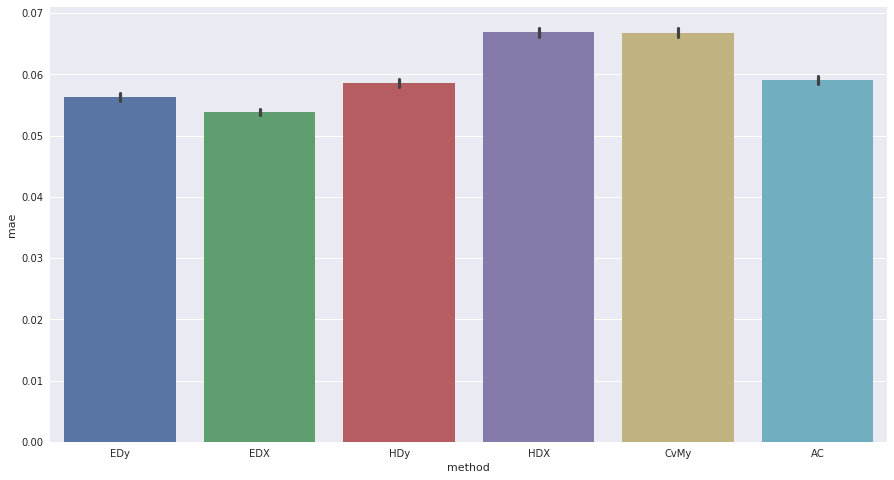

In [6]:
_, ax = plt.subplots(1,1,figsize=(15, 8))
sns.barplot(x="method", y="mae", data=results, 
            #order=["AC_linear", "AC_nonlinear", "AC_nonlinear_geometric", "EDX", "EDy_linear", "EDy_nonlinear", 
            #       "EDy_nonlinear_geometric", "HDX", "HDy_linear", "HDy_nonlinear", "HDy_nonlinear_geometric"]
           )

## Baycomp

In [6]:
from baycomp.utils import import_plt
from math import sqrt, sin, cos, pi

def plot_simplex(test, ax, names=None):
    """
    Plot the posterior distribution in a simplex.

    The distribution is shown as a triangle with regions corresponding to
    first classifier having higher scores than the other by more than rope,
    the second having higher scores, or the difference being within the
    rope.

    Args:
        names (tuple of str): names of classifiers
    """

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    def project(points):
        p1, p2, p3 = points.T / sqrt(3)
        x = (p2 - p1) * cos(pi / 6) + 0.5
        y = p3 - (p1 + p2) * sin(pi / 6) + 1 / (2 * sqrt(3))
        return np.vstack((x, y)).T

    ax.set_aspect('equal', 'box')

    # triangle
    ax.add_line(Line2D([0, 0.5, 1.0, 0],
                       [0, np.sqrt(3) / 2, 0, 0], color='orange'))
    names = names or test.names or ("C1", "C2")
    pl, pe, pr = test.probs()
    ax.text(0, -0.04,
            'p({}) = {:.3f}'.format(names[0], pl),
            horizontalalignment='center', verticalalignment='top')
    ax.text(0.5, np.sqrt(3) / 2,
            'p(rope) = {:.3f}'.format(pe),
            horizontalalignment='center', verticalalignment='bottom')
    ax.text(1, -0.04,
            'p({}) = {:.3f}'.format(names[1], pr),
            horizontalalignment='center', verticalalignment='top')
    cx, cy = project(np.array([[0.3333, 0.3333, 0.3333]]))[0]
    for x, y in project(np.array([[.5, .5, 0], [.5, 0, .5], [0, .5, .5]])):
        ax.add_line(Line2D([cx, x], [cy, y], color='orange'))

    # project and draw points
    tripts = project(test.sample[:, [0, 2, 1]])
    ax.hexbin(tripts[:, 0], tripts[:, 1], mincnt=1, cmap=plt.cm.Blues_r)
    # Leave some padding around the triangle for vertex labels
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.axis('off')

# Hierarchical Test

In [ ]:
def get_data(method, aggregate=False):
    results = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")

    results = results[results.method == method].sort_values("dataset")
    maes = results["mae"].values.reshape(41, -1)
    if aggregate:
        maes = maes.mean(axis=1)

    inv_maes = 1 - maes
    return inv_maes

from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

prob_df = pd.DataFrame(columns=["Cuantificador1", "Cuantificador2", "p(m1)", "p(rope)", "p(m2)"])

methods = ["EDX", "EDy", "HDX", "HDy", "AC", "CvMy"]

methods_combs = combinations(methods, 2)

fig, axs = plt.subplots(len(methods), len(methods), figsize=(25, 25))
_ = [axs[i][i].axis("off") for i in range(len(methods))]
_ = [axs[i][i].text(0.32, 0.42, methods[i], fontsize=60) for i in range(len(methods))]
for m1, m2 in methods_combs:
    i, j = methods.index(m1), methods.index(m2)
    try:
        data_hdx = get_data(m1)
        data_hdy = get_data(m2)

        test = bc.HierarchicalTest(data_hdx, data_hdy, 0.01, runs=1)
        plot_simplex(test, axs[i][j], names=(m1, m2))
        plot_simplex(test, axs[j][i], names=(m1, m2))
        extent = full_extent(axs[i][j]).transformed(fig.dpi_scale_trans.inverted())
        fig.tight_layout()
        fig.savefig("figures/Hierarchical20x50_{}_vs_{}.png".format(m1, m2), bbox_inches=extent)
    except RuntimeError as err:
        print("Failed Hierarchical Test between ", m1, m2, err)
        
    prob_df = prob_df.append(pd.DataFrame([[m1, m2] + list(test.probs())], columns=["Cuantificador1", "Cuantificador2", "p(m1)", "p(rope)", "p(m2)"]))

fig.tight_layout()
fig.savefig("figures/Hierarchical_20x50bags.png")

/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
Process ForkPoolWorker-136:
Traceback (most recent call last):
Process ForkPoolWorker-129:
Traceback (most recent call last):
Process ForkPoolWorker-133:
Process ForkPoolWorker-130:
Process ForkPoolWorker-137:
Process ForkPoolWorker-131:
Process ForkPoolWorker-139:
Process ForkPoolWorker-138:
Process ForkPoolWorker-128:
Process ForkPoolWorker-134:
Process ForkPoolWorker-135:
Process ForkPoolWorker-127:
Process ForkPoolWorker-140:
Process ForkPoolWorker-126:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-132:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (m

In [7]:
prob_df = pd.read_csv("prob_test_20x50.csv")

# Sign Test

In [ ]:
fig, axs = plt.subplots(len(methods), len(methods), figsize=(25, 25))
_ = [axs[i][i].axis("off") for i in range(len(methods))]
_ = [axs[i][i].text(0.32, 0.42, methods[i], fontsize=60) for i in range(len(methods))]

methods_combs = combinations(methods, 2)

for m1, m2 in methods_combs:
    i, j = methods.index(m1), methods.index(m2)
    try:
        data_hdx = get_data(m1, aggregate=True)
        data_hdy = get_data(m2, aggregate=True)

        test = bc.SignTest(data_hdx, data_hdy, 0.01)
        plot_simplex(test, axs[i][j], names=(m1, m2))
        plot_simplex(test, axs[j][i], names=(m1, m2))
    except RuntimeError as err:
        print("Failed Signed Test between ", m1, m2, err)
    
    plt.savefig("figures/Signed_20x50bags.png")

fig.tight_layout()

In [ ]:
def get_data_one_ds(method, dataset, aggregate=False):
    results = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")

    results = results[np.logical_and(results.method == method, results.dataset == dataset)]
    maes = results["mae"].values

    if aggregate:
        maes = maes.mean(axis=1)

    inv_maes = 1 - maes
    return inv_maes

datasets_dir = "datasets"
dataset_files = [file for file in glob.glob(os.path.join(datasets_dir, "*.csv")) if file not in ["datasets/balance.2.csv", "datasets/lettersG.csv", "datasets/k9.csv"]]
dataset_names = [os.path.split(name)[-1][:-4] for name in dataset_files]

In [ ]:
methods = ["EDX", "EDy", "HDX", "HDy", "AC", "CvMy"]

methods_combs = combinations(methods, 2)
two_on_single_df = pd.DataFrame(columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"])

for m1, m2 in tqdm(methods_combs):
    for dname in dataset_names:
        data1 = get_data_one_ds(m1, dname)
        data2 = get_data_one_ds(m2, dname)
        test = bc.two_on_single(data1, data2, rope=0.01)
        two_on_single_df = two_on_single_df.append(pd.DataFrame([[m1, m2, dname] + list(test)], columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"]))
two_on_single_df["Par"] = two_on_single_df.Cuantificador1 + "-" + two_on_single_df.Cuantificador2

In [ ]:
two_on_single_df[["n(m1)", "n(rope)", "n(m2)"]] = (two_on_single_df[["p(m1)", "p(rope)", "p(m2)"]] > 0.95)
final_df = two_on_single_df.groupby("Par").sum()[["n(m1)", "n(rope)", "n(m2)"]]
final_df["n(no_decision)"] = 41 - final_df["n(m1)"] - final_df["n(m2)"] - final_df["n(rope)"]
final_df.sum() / 615

In [ ]:
data1 = get_data_one_ds("EDX", "coil")
data2 = get_data_one_ds("EDy", "coil")
test = bc.two_on_single(data1, data2, rope=0.01, plot=True)

In [9]:
prob_df

,Cuantificador1,Cuantificador2,p(m1),p(rope),p(m2)


In [8]:
print(prob_df.to_latex(index=None))

\begin{tabular}{lllll}
\toprule
Empty DataFrame
Columns: Index(['Cuantificador1', 'Cuantificador2', 'p(m1)', 'p(rope)', 'p(m2)'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}

